In [1]:
import os
from pathlib import Path
import re

import numpy as np
import pandas as pd
from rdkit import Chem

cwd = os.getcwd()
if cwd.endswith('notebook/PG'):
    os.chdir('../..')
    cwd = os.getcwd()

from src.pg_modelling.ligand_utils import sanitize_ligand_name, parse_plip_output

In [2]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
sns.set_palette('colorblind')
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.8)
plt.rcParams['font.family'] = 'Helvetica'

palette = sns.color_palette().as_hex()

In [3]:
pg_modelling_folder = Path(os.path.expanduser('~')) / 'Documents' / 'PG_modelling'
data_folder = pg_modelling_folder / 'Human_Lysozyme_C_P61626'
assert data_folder.is_dir()

# Human Lysozyme C

Ligands:
- NAG-NAM-sidechain from S. aureus (positive control)
- NAG-NAM-sidechain from E. coli (positive control)
- G-MUR-sidechain from S. aureus (negative control)
- G-MUR-sidechain from E. coli (negative control)
- Any odd lipid in the same molecular weight ballpark (negative control)

In [4]:
E_coli_libary = pg_modelling_folder / 'PG_library' / 'Escherichia_coli' / 'E_coli_cell_wall_library.xlsx'
S_aureus_libary = pg_modelling_folder / 'PG_library' / 'Staphylococcus_aureus' / 'S_aureus_cell_wall_library.xlsx'

pg_library = pd.concat(
    [
        pd.read_excel(
            E_coli_libary,
            sheet_name=0,
        ),
        pd.read_excel(
            E_coli_libary,
            sheet_name=1,
        ),
        pd.read_excel(
            S_aureus_libary,
            sheet_name=0,
        ),
        pd.read_excel(
            S_aureus_libary,
            sheet_name=1,
        ),
    ],
    ignore_index=True,
)
pg_library['ligand_id'] = pg_library['Name'].apply(sanitize_ligand_name)
pg_library = pg_library.drop_duplicates('ligand_id')
pg_library = pg_library.set_index('ligand_id')
print(f'N = {len(pg_library):,}')

N = 2,089


In [5]:
subset_ids = [
    'NAG-NAM-AqKA',
    'G-MUR-AqKA',
    'NAG-NAM-AemA',
    'G-MUR-AemA',
]
pg_library_subset = pg_library.loc[subset_ids].rename(columns={
    'SMILES': 'smiles',
    'Monoisotopic Mass': 'mass',
})[['smiles', 'mass']]
print(f'N = {len(pg_library_subset):,}')
pg_library_subset

N = 4


,smiles,mass
ligand_id,,
NAG-NAM-AqKA,CC(=O)NC1C(OC2C(CO)OC(O)C(NC(C)=O)C2OC(C)C(=O)...,894.41821
G-MUR-AqKA,CC(NC(=O)C(CCCCN)NC(=O)CCC(NC(=O)C(C)NC(=O)C(C...,810.39708
NAG-NAM-AemA,CC(=O)NC1C(OC2C(CO)OC(O)C(NC(C)=O)C2OC(C)C(=O)...,939.39205
G-MUR-AemA,CC(NC(=O)C(CCCC(N)C(=O)O)NC(=O)CCC(NC(=O)C(C)N...,855.37092


In [6]:
# Pick larg-ish lipid from E. coli: (3S)-citryl-CoA
lipid_maps = pd.read_csv(pg_modelling_folder / 'PG_library' / 'lipid_maps' / 'lipids.csv')
lipid_df = lipid_maps[lipid_maps['NAME'] == '(3S)-citryl-CoA'].copy()
lipid_df['ligand_id'] = lipid_df['NAME'].apply(lambda n: f'lipid-{sanitize_ligand_name(n)}')
lipid_df = lipid_df.set_index('ligand_id').rename(columns={
    'SMILES': 'smiles',
    'EXACT_MASS': 'mass',
})[['smiles', 'mass']]

ligands_df = pd.concat([pg_library_subset, lipid_df])
ligands_df.to_csv(data_folder / 'ligands.csv')
print(f'N = {len(ligands_df):,}')
ligands_df

N = 5


,smiles,mass
ligand_id,,
NAG-NAM-AqKA,CC(=O)NC1C(OC2C(CO)OC(O)C(NC(C)=O)C2OC(C)C(=O)...,894.418210
G-MUR-AqKA,CC(NC(=O)C(CCCCN)NC(=O)CCC(NC(=O)C(C)NC(=O)C(C...,810.397080
NAG-NAM-AemA,CC(=O)NC1C(OC2C(CO)OC(O)C(NC(C)=O)C2OC(C)C(=O)...,939.392050
G-MUR-AemA,CC(NC(=O)C(CCCC(N)C(=O)O)NC(=O)CCC(NC(=O)C(C)N...,855.370920
lipid-3S-citryl-CoA,CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc...,941.131659


## Results

In [7]:
binding_sites = {
    ('Glu', 53),
    ('Asp', 71),
}
def parse_results(path):
    df = pd.read_csv(path, index_col='ligand_name')
    df['aev_plig_pK_norm'] = df.apply(
        lambda row: row['aev_plig_pK'] / (ligands_df.loc[row.name, 'mass'] / 1000),
        axis=1,
    )
    df['binding_site'] = df['structure_file'].apply(interact_with_binding_site)
    return df


def interact_with_binding_site(structure_path_str : str) -> bool:
    p = data_folder / 'modelling' / re.sub(r'^.*?modelling/', '', structure_path_str.replace('.cif', '_plip')) / 'report.xml'
    if not p.is_file():
        return False
    
    plip_df = parse_plip_output(p)
    for residue_name, residue_number in plip_df[['residue_name', 'residue_number']].values:
        key = (residue_name.title(), residue_number)
        if key in binding_sites:
            return True
    return False


In [10]:
def sort_and_drop_duplicates(df):
    out_df = df.reset_index().sort_values(
        [
            'protein_name', 'ligand_name', 'posebusters_score', 'confidence', 'aev_plig_pK'
        ],
        ascending=False,
    ).drop_duplicates(
        ['protein_name', 'ligand_name']
    ).set_index('ligand_name')

    return out_df.sort_values(
        [
            'posebusters_score', 'confidence', 'aev_plig_pK'
        ],
        ascending=False
    )

In [11]:
colors = {
    'NAG-NAM-AqKA': '#3cb44b',
    'G-MUR-AqKA': '#e6194B',
    'NAG-NAM-AemA': '#4363d8',
    'G-MUR-AemA': '#9A6324',
    'lipid-3S-citryl-CoA': '#aaaaaa',
}
def plot_confidence_vs_pk(df):
    ligands = sorted(set(df.index))

    df_bs = df[df['binding_site']]
    df_no_bs = df[~df['binding_site']]

    ax = df_bs.plot.scatter(
        x='confidence', 
        y='aev_plig_pK_norm',
        c=[colors[l] for l in df_bs.index],
        alpha=[
            1.0 if row['posebusters_score'] == 20 else 0.2
            for _, row in df_bs.iterrows()
        ],
        marker='o',
    );
    df_no_bs.plot.scatter(
        x='confidence', 
        y='aev_plig_pK_norm',
        c=[colors[l] for l in df_no_bs.index],
        alpha=[
            1.0 if row['posebusters_score'] == 20 else 0.2
            for _, row in df_no_bs.iterrows()
        ],
        marker='x',
        ax=ax,
    );
    ax.set_ylabel('Predicted pK per kDa');
    legend_handles = [
        mlines.Line2D([], [], color=colors[l], marker='o', linestyle='None', markersize=6, label=l)
        for l in ligands
    ]
    ax.legend(handles=legend_handles, bbox_to_anchor=(1.0, 1.0), frameon=False);

### AF3

In [12]:
af3_results_all = parse_results(data_folder / 'modelling' / 'af3' / 'scores.csv')
af3_results = sort_and_drop_duplicates(af3_results_all)
af3_results

,protein_name,seed,sample,structure_file,ptm,iptm,confidence,posebusters_score,energy_ratio,posebusters_errors,aev_plig_pK,aev_plig_pK_norm,binding_site
ligand_name,,,,,,,,,,,,,
NAG-NAM-AqKA,Human_Lysozyme_C_P61626,853,3,/home/rs1521/PG/Human_Lysozyme_C_P61626/modell...,0.83,0.77,0.782,20,3.4,NaN,5.62,6.283414,True
NAG-NAM-AemA,Human_Lysozyme_C_P61626,639,2,/home/rs1521/PG/Human_Lysozyme_C_P61626/modell...,0.80,0.71,0.728,20,3.1,NaN,5.45,5.801625,False
G-MUR-AqKA,Human_Lysozyme_C_P61626,914,3,/home/rs1521/PG/Human_Lysozyme_C_P61626/modell...,0.80,0.65,0.680,20,2.8,NaN,5.63,6.947212,True
lipid-3S-citryl-CoA,Human_Lysozyme_C_P61626,85,2,/home/rs1521/PG/Human_Lysozyme_C_P61626/modell...,0.79,0.64,0.670,20,3.7,NaN,6.19,6.577188,True
G-MUR-AemA,Human_Lysozyme_C_P61626,85,0,/home/rs1521/PG/Human_Lysozyme_C_P61626/modell...,0.77,0.58,0.618,20,2.3,NaN,5.13,5.997398,False


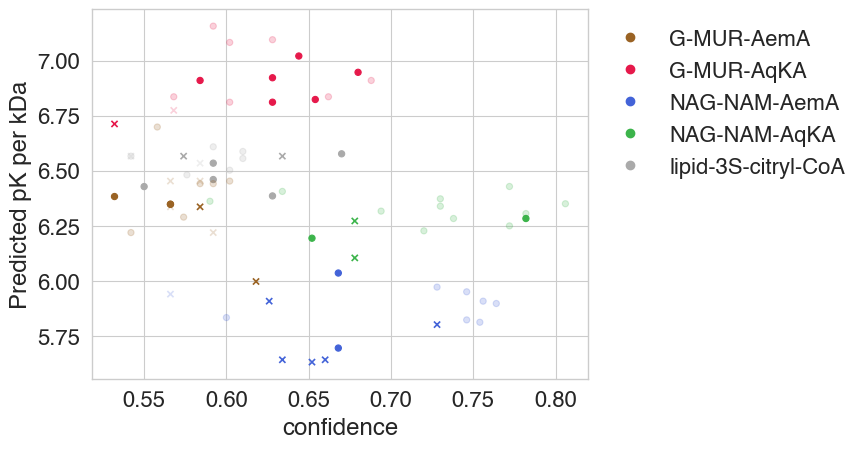

In [13]:
plot_confidence_vs_pk(af3_results_all);

### Boltz

In [14]:
boltz_results_all = parse_results(data_folder / 'modelling' / 'boltz' / 'scores.csv')
boltz_results = sort_and_drop_duplicates(boltz_results_all)
boltz_results

,protein_name,seed,sample,structure_file,ptm,iptm,confidence,posebusters_score,energy_ratio,posebusters_errors,aev_plig_pK,aev_plig_pK_norm,binding_site
ligand_name,,,,,,,,,,,,,
G-MUR-AemA,Human_Lysozyme_C_P61626,335,0,/gpfs/home/rs1521/PG/Human_Lysozyme_C_P61626/m...,0.825203,0.695957,0.722,20,4.3,NaN,5.58,6.523486,True
lipid-3S-citryl-CoA,Human_Lysozyme_C_P61626,765,1,/gpfs/home/rs1521/PG/Human_Lysozyme_C_P61626/m...,0.793693,0.598686,0.638,20,4.0,NaN,6.09,6.470933,False
NAG-NAM-AqKA,Human_Lysozyme_C_P61626,765,4,/gpfs/home/rs1521/PG/Human_Lysozyme_C_P61626/m...,0.786407,0.575592,0.618,20,4.6,NaN,5.72,6.395219,False
NAG-NAM-AemA,Human_Lysozyme_C_P61626,765,0,/gpfs/home/rs1521/PG/Human_Lysozyme_C_P61626/m...,0.774670,0.529539,0.579,20,3.8,NaN,5.63,5.993238,False
G-MUR-AqKA,Human_Lysozyme_C_P61626,765,1,/gpfs/home/rs1521/PG/Human_Lysozyme_C_P61626/m...,0.767950,0.484613,0.541,20,6.6,NaN,5.82,7.181665,False


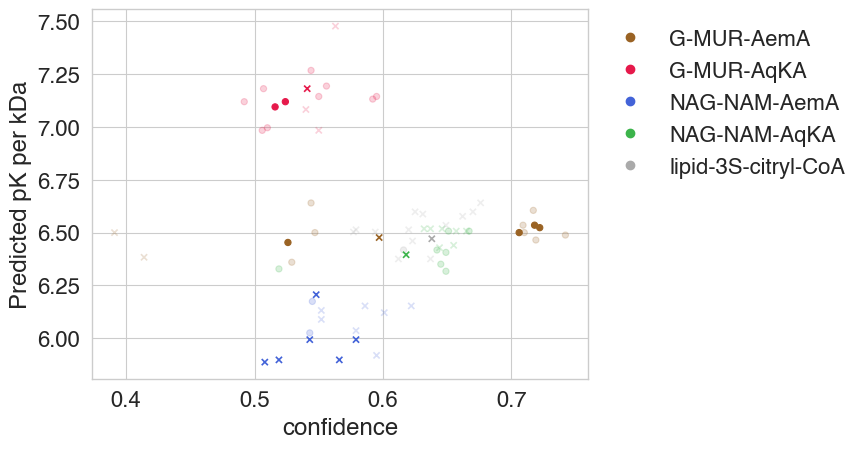

In [15]:
plot_confidence_vs_pk(boltz_results_all);

### Chai

In [16]:
chai_results_all = parse_results(data_folder / 'modelling' / 'chai' / 'scores.csv')
chai_results = sort_and_drop_duplicates(chai_results_all)
chai_results

,protein_name,seed,sample,structure_file,ptm,iptm,confidence,posebusters_score,energy_ratio,posebusters_errors,aev_plig_pK,aev_plig_pK_norm,binding_site
ligand_name,,,,,,,,,,,,,
NAG-NAM-AemA,Human_Lysozyme_C_P61626,842,4,/gpfs/home/rs1521/PG/Human_Lysozyme_C_P61626/m...,0.894738,0.683071,0.725,20,2.7,NaN,5.53,5.886786,True
G-MUR-AqKA,Human_Lysozyme_C_P61626,536,0,/gpfs/home/rs1521/PG/Human_Lysozyme_C_P61626/m...,0.901146,0.647984,0.699,20,2.7,NaN,5.48,6.762117,True
NAG-NAM-AqKA,Human_Lysozyme_C_P61626,536,1,/gpfs/home/rs1521/PG/Human_Lysozyme_C_P61626/m...,0.890993,0.640934,0.691,20,11.7,NaN,5.58,6.238692,False
lipid-3S-citryl-CoA,Human_Lysozyme_C_P61626,842,3,/gpfs/home/rs1521/PG/Human_Lysozyme_C_P61626/m...,0.884038,0.629107,0.680,20,4.1,NaN,6.15,6.534686,False
G-MUR-AemA,Human_Lysozyme_C_P61626,842,2,/gpfs/home/rs1521/PG/Human_Lysozyme_C_P61626/m...,0.878530,0.573250,0.634,20,2.3,NaN,5.50,6.429959,True


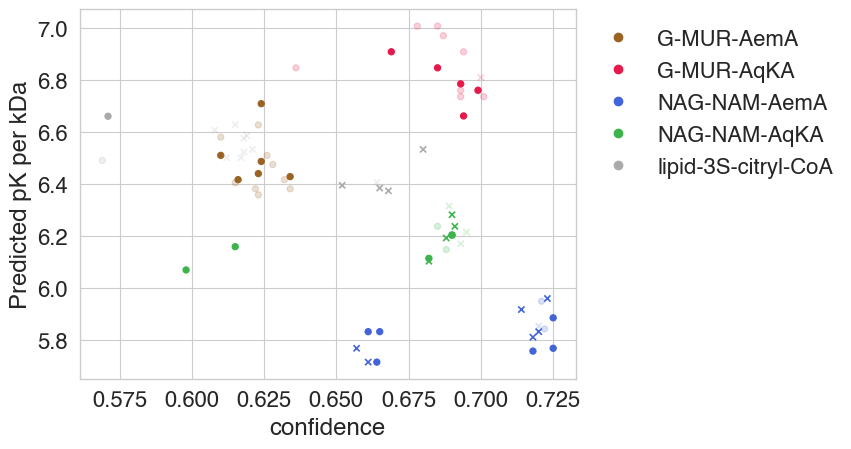

In [17]:
plot_confidence_vs_pk(chai_results_all);

### Protenix

In [18]:
protenix_results_all = parse_results(data_folder / 'modelling' / 'protenix' / 'scores.csv')
protenix_results = sort_and_drop_duplicates(protenix_results_all)
protenix_results

,protein_name,seed,sample,structure_file,ptm,iptm,confidence,posebusters_score,energy_ratio,posebusters_errors,aev_plig_pK,aev_plig_pK_norm,binding_site
ligand_name,,,,,,,,,,,,,
G-MUR-AqKA,Human_Lysozyme_C_P61626,27,0,/gpfs/home/rs1521/PG/Human_Lysozyme_C_P61626/m...,0.965841,0.976836,0.975,20,2.4,NaN,5.60,6.910193,True
G-MUR-AemA,Human_Lysozyme_C_P61626,560,2,/gpfs/home/rs1521/PG/Human_Lysozyme_C_P61626/m...,0.964103,0.975872,0.974,20,3.6,NaN,5.50,6.429959,True
NAG-NAM-AemA,Human_Lysozyme_C_P61626,560,1,/gpfs/home/rs1521/PG/Human_Lysozyme_C_P61626/m...,0.958416,0.971451,0.969,20,56.2,NaN,5.44,5.790979,True
NAG-NAM-AqKA,Human_Lysozyme_C_P61626,27,1,/gpfs/home/rs1521/PG/Human_Lysozyme_C_P61626/m...,0.959891,0.966277,0.965,20,3.1,NaN,5.47,6.115707,True
lipid-3S-citryl-CoA,Human_Lysozyme_C_P61626,560,1,/gpfs/home/rs1521/PG/Human_Lysozyme_C_P61626/m...,0.957388,0.955664,0.956,20,3.9,NaN,6.24,6.630316,False


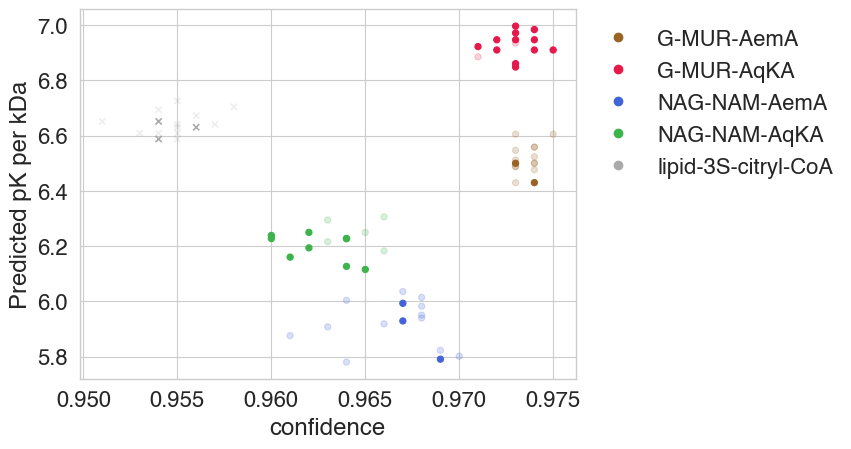

In [19]:
plot_confidence_vs_pk(protenix_results_all);